In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
image_size=224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0xb39358320> False
<keras.layers.convolutional.Conv2D object at 0xb393588d0> False
<keras.layers.convolutional.Conv2D object at 0xb39358748> False
<keras.layers.pooling.MaxPooling2D object at 0xb39378908> False
<keras.layers.convolutional.Conv2D object at 0xb39378748> False
<keras.layers.convolutional.Conv2D object at 0xb393b91d0> False
<keras.layers.pooling.MaxPooling2D object at 0xb393d3668> False
<keras.layers.convolutional.Conv2D object at 0xb393d34e0> False
<keras.layers.convolutional.Conv2D object at 0xb393f3c18> False
<keras.layers.convolutional.Conv2D object at 0xb39426160> False
<keras.layers.pooling.MaxPooling2D object at 0xb39445630> False
<keras.layers.convolutional.Conv2D object at 0xb394454a8> False
<keras.layers.convolutional.Conv2D object at 0xb39464dd8> False
<keras.layers.convolutional.Conv2D object at 0xb394980b8> False
<keras.layers.pooling.MaxPooling2D object at 0xb394b3668> False
<keras.layers.convolutional.Conv2D obj

In [3]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(37, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 37)                4773      
Total para

In [5]:
model_fname = '/content/drive/Colab Notebooks/mafat_model'
train_batchsize = 25
df = pd.read_csv('data/Dataset for participants V2/train_binarified.csv')
train_images_dir = 'data/train/'

#Train generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=8,
    height_shift_range=14,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.05, 1.2],
    fill_mode='constant')

binary_labels = ['small vehicle','large vehicle','minibus','hatchback','sedan','bus',
                 'minivan','truck','van','jeep','cement mixer','dedicated agricultural vehicle','tanker',
                 'crane truck','pickup','light truck','prime mover','red','black','blue','silver/grey','white',
                 'other','yellow','green','sunroof','luggage_carrier','open_cargo_area','enclosed_cab','spare_wheel',
                 'wrecked','flatbed','ladder','enclosed_box','soft_shell_box','harnessed_to_a_cart','ac_vents']

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_images_dir,
    x_col='imagefn',
    y_col=binary_labels,
    has_ext=True,
    target_size=(image_size, image_size),
    class_mode='other',
    batch_size=train_batchsize,
    subset="training",
    shuffle=True,
    seed=42)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_images_dir,
    x_col='imagefn',
    y_col=binary_labels,
    has_ext=True,
    target_size=(image_size, image_size),
    class_mode='other',
    batch_size=train_batchsize,
    subset="validation",
    shuffle=True,
    seed=42)

Found 9294 images.
Found 2323 images.


In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc'])

# Calculate class weight
# counter = Counter(train_generator.classes)                          
# max_val = float(max(counter.values()))       
# class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

# Save checkpoint when val_loss is minimal
filepath = model_fname + '.{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model
history = model.fit_generator(
      train_generator,
#       class_weight=class_weights,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      epochs=50,
      callbacks=callbacks_list,
      verbose=1)
 
# Save the model
model.save(model_fname + '.final.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Found 2324 images belonging to 2 classes.
233/232 [==============================] - 936s 4s/step
No of errors = 80/2324


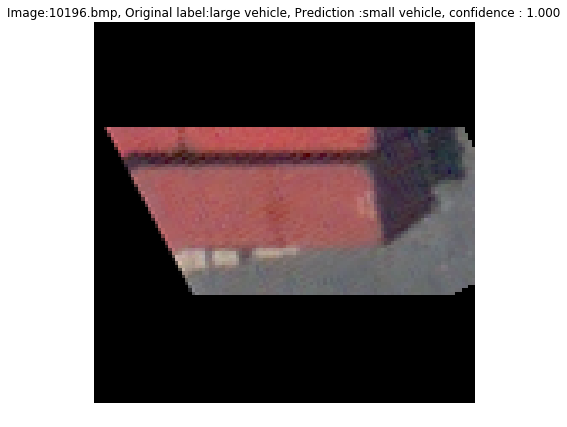

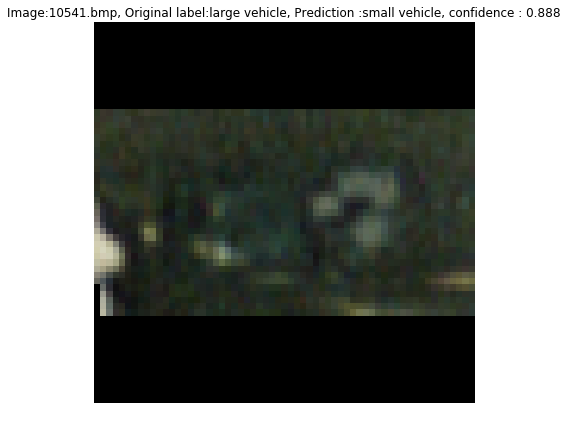

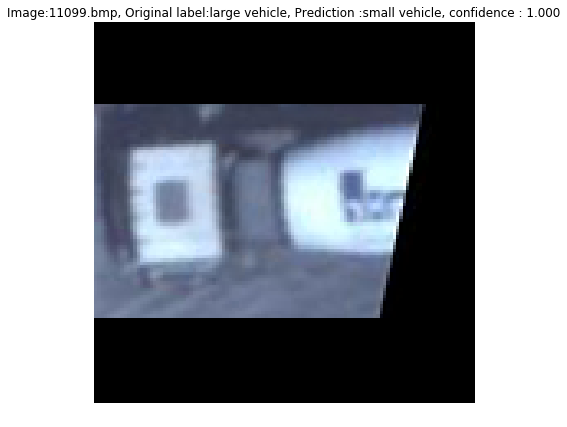

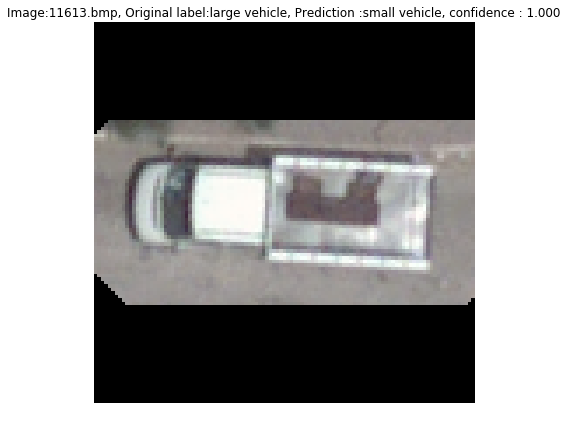

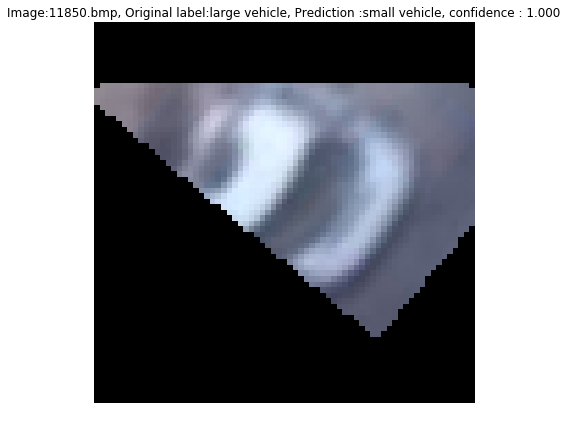

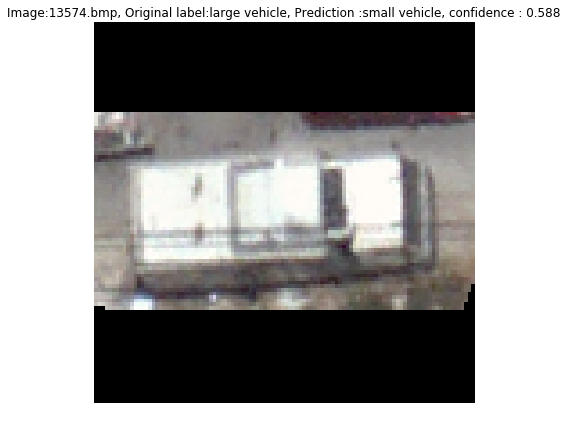

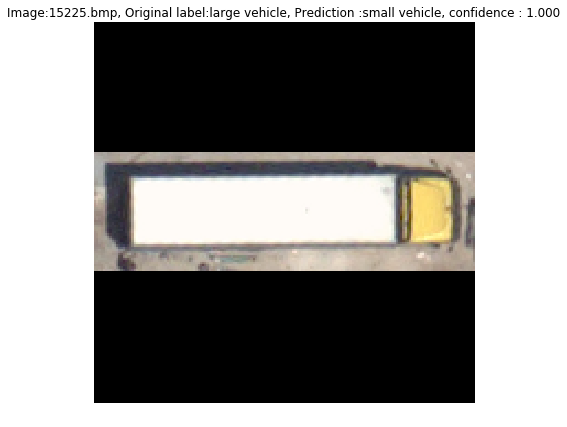

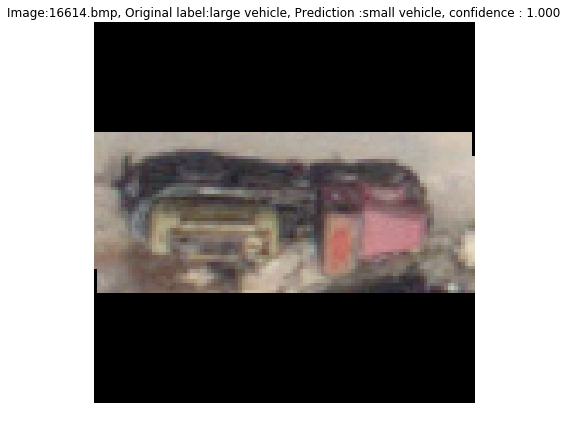

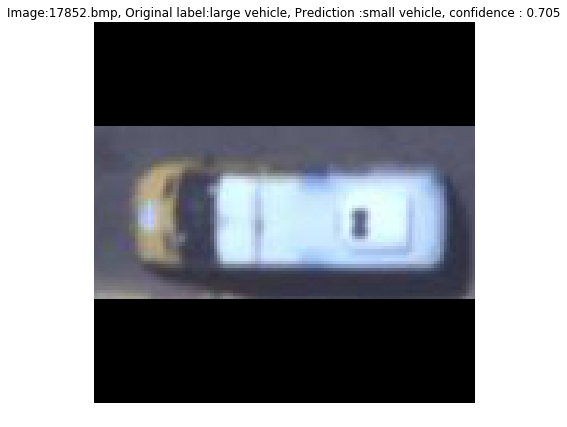

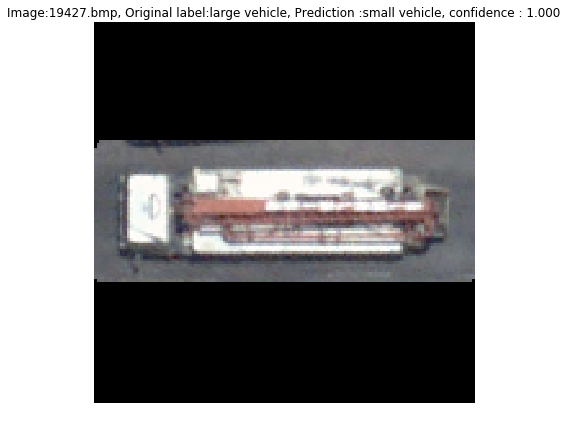

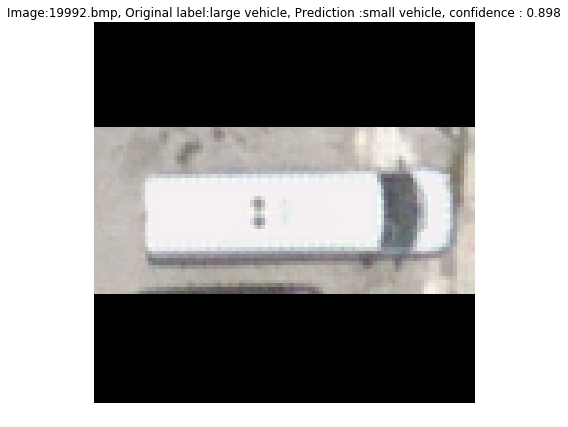

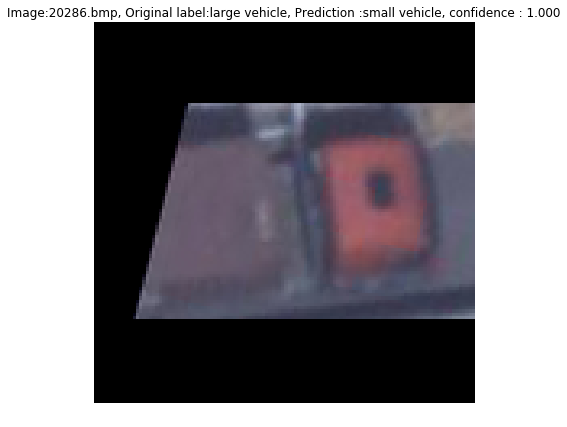

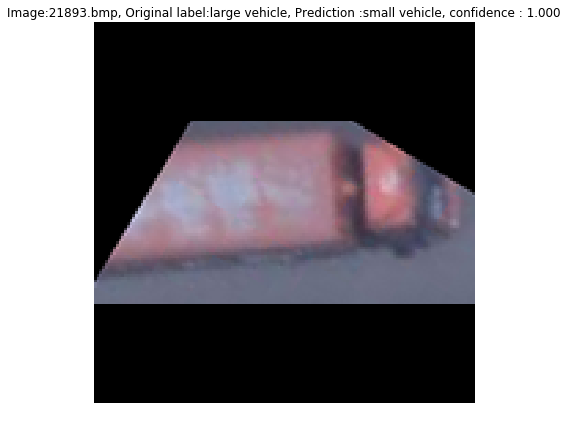

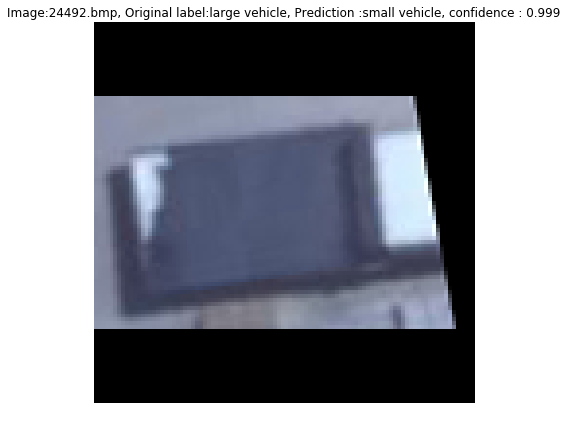

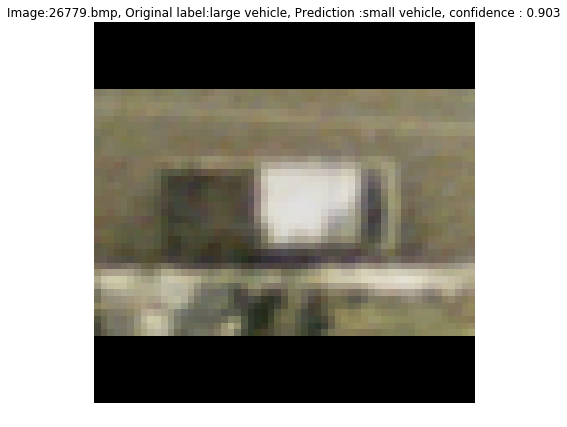

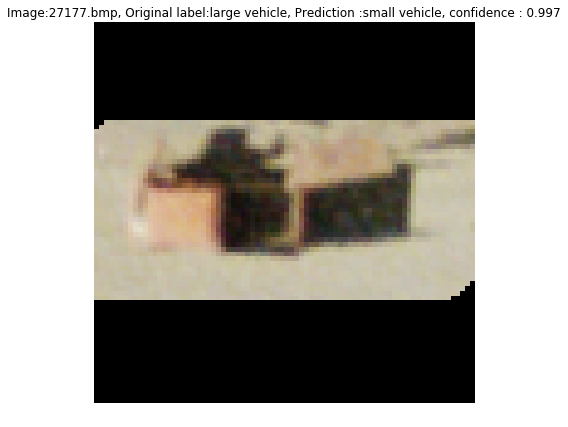

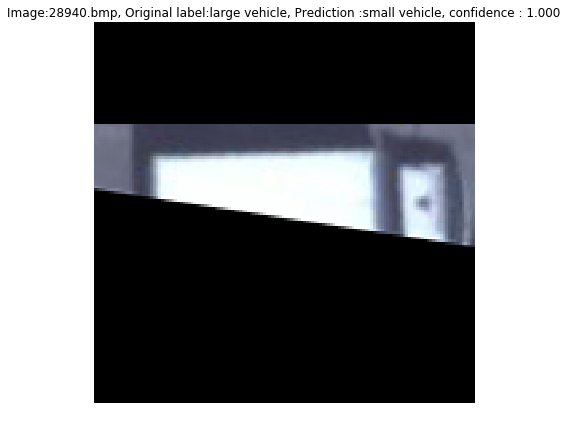

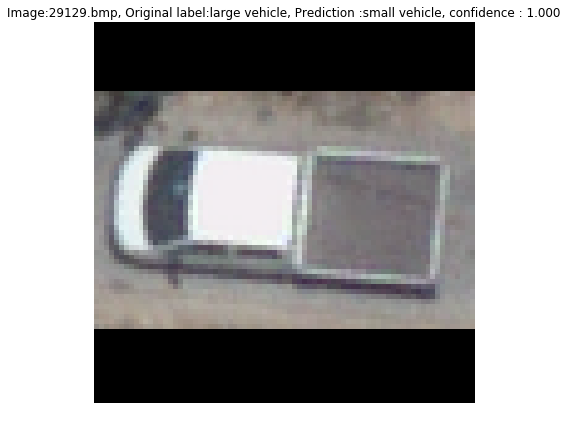

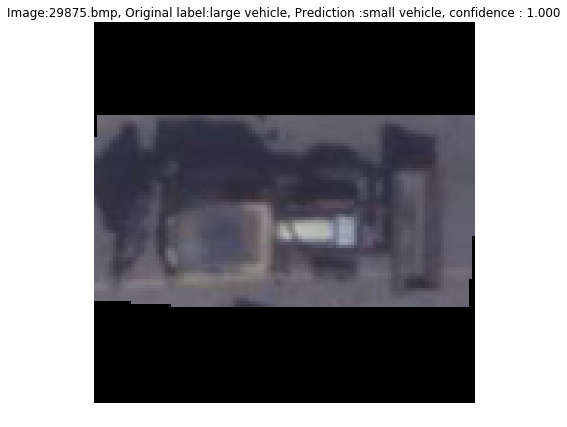

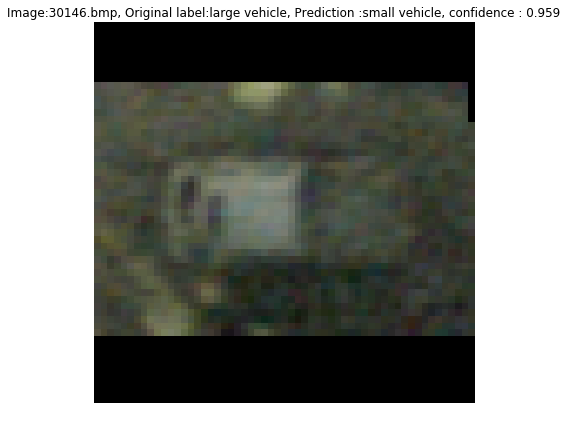

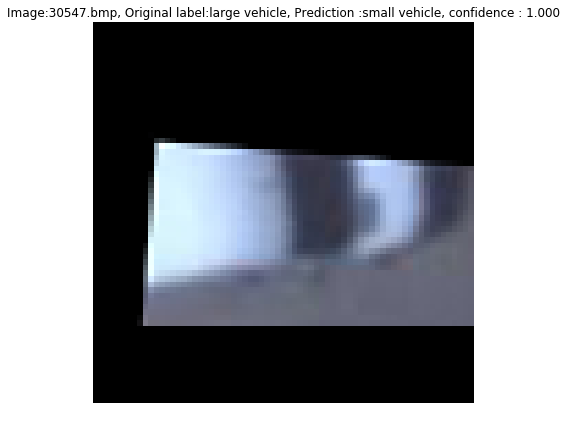

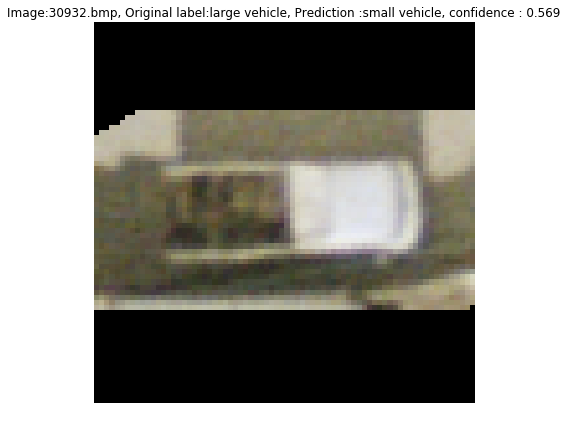

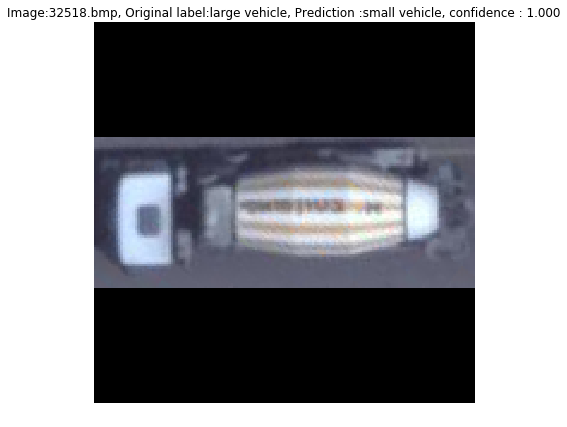

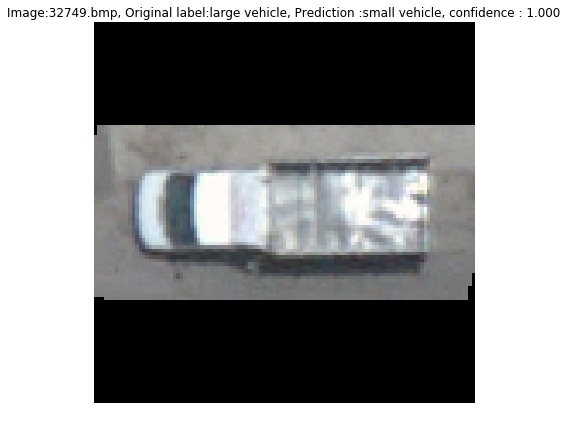

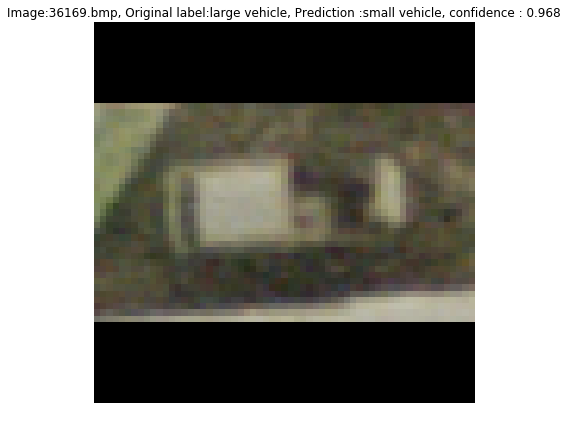

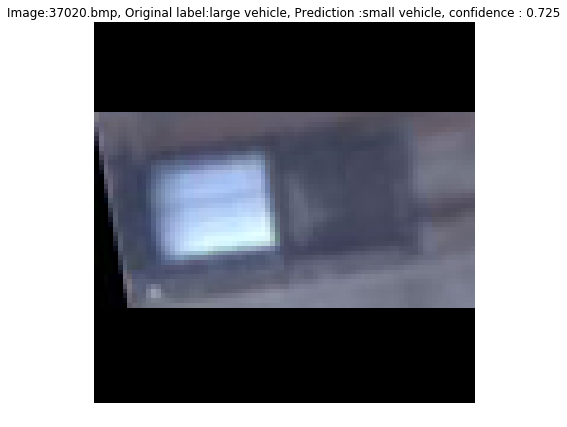

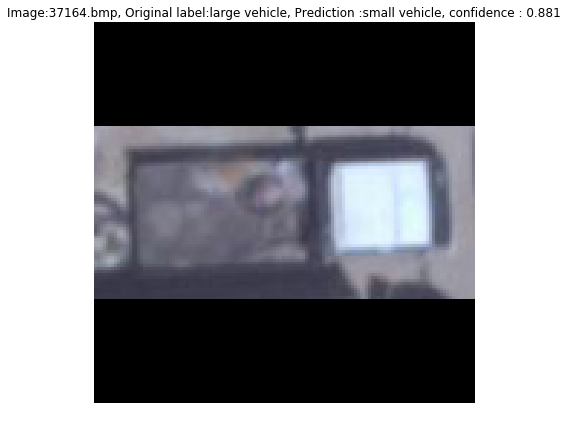

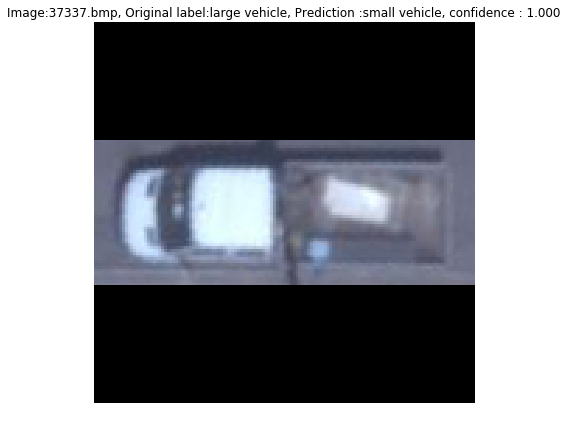

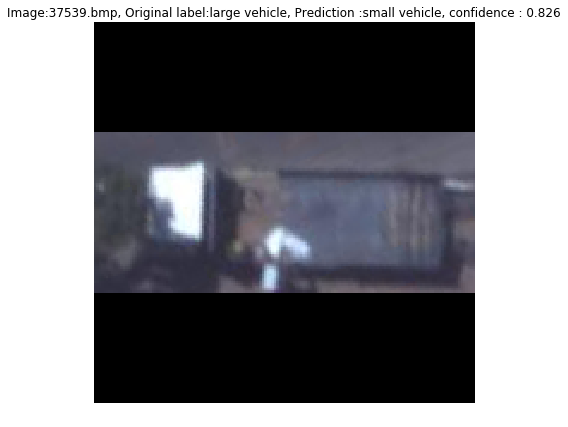

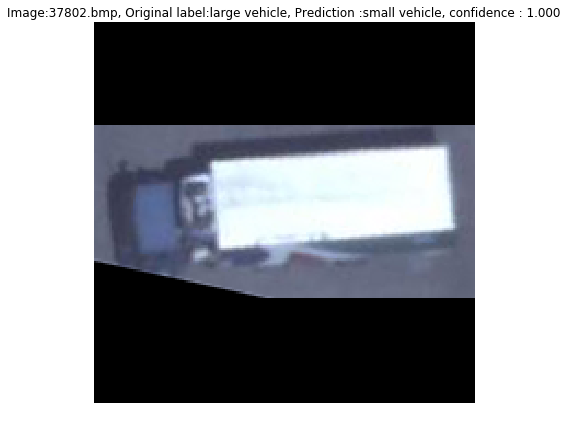

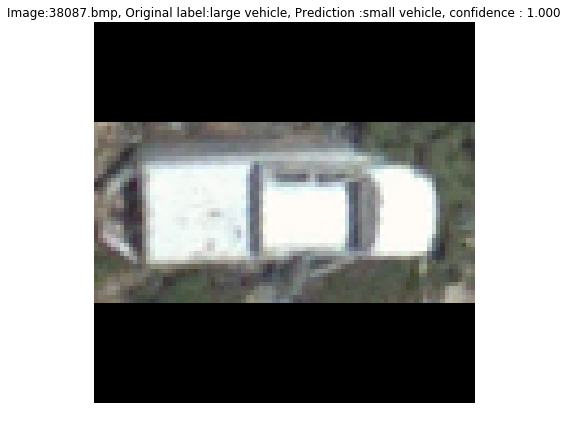

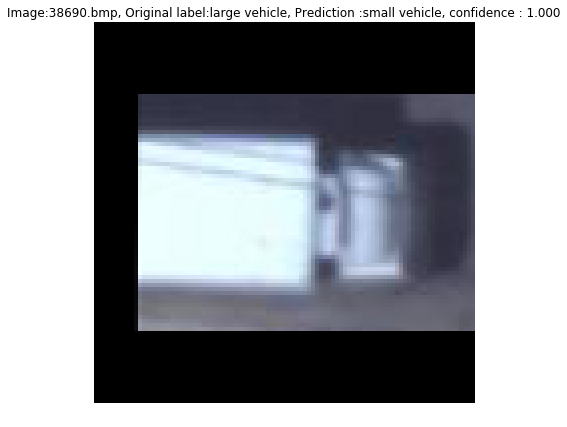

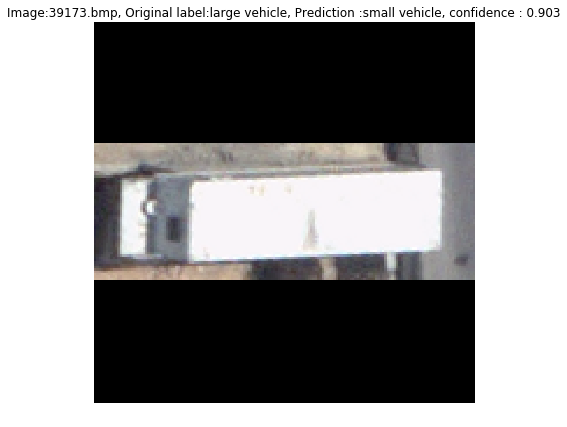

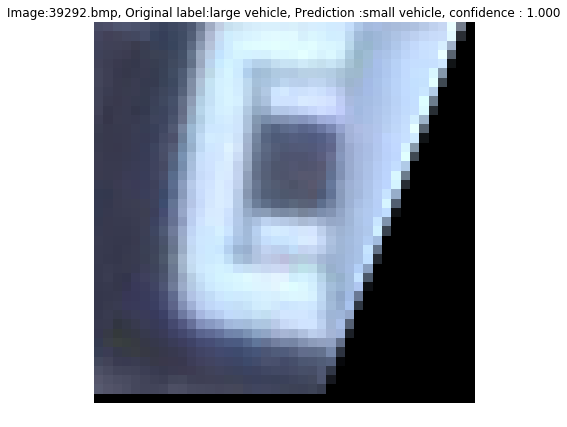

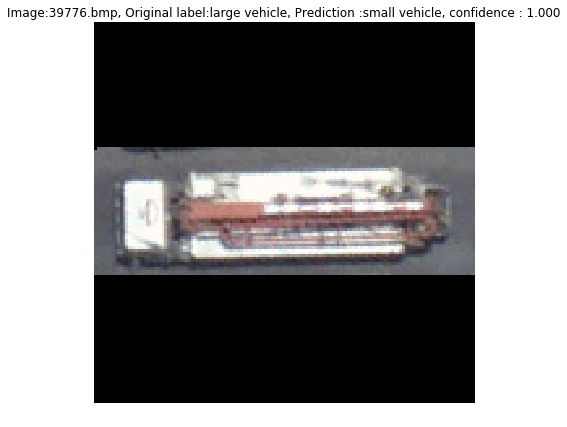

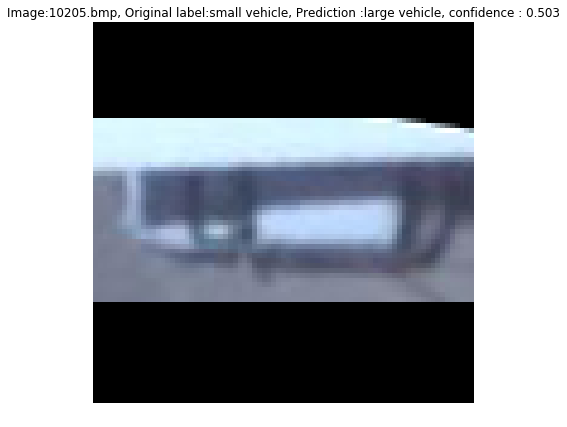

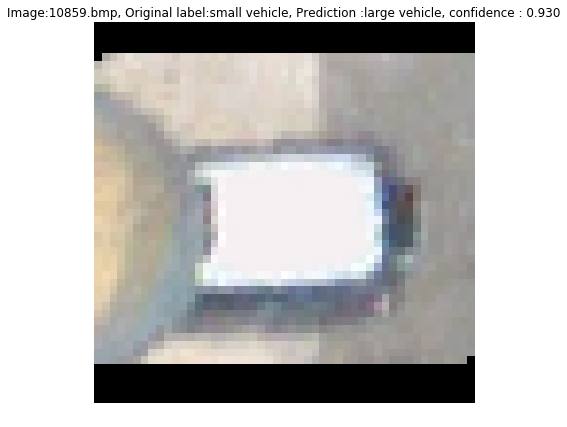

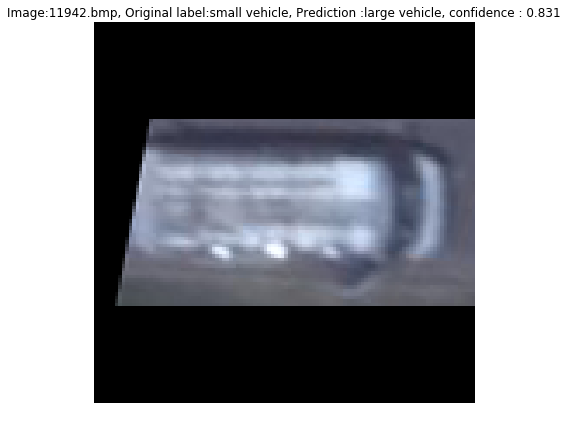

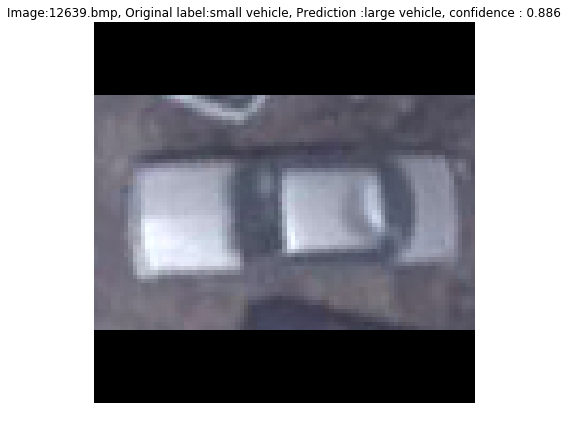

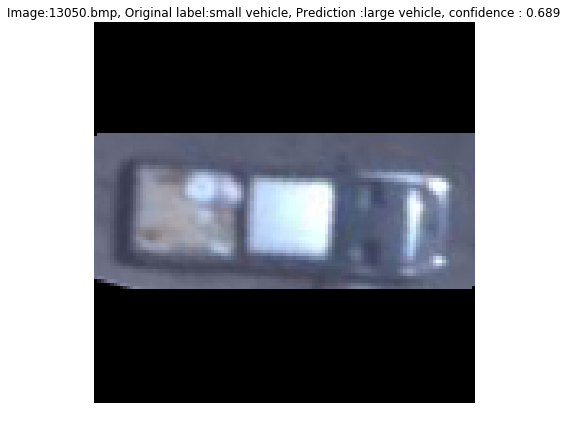

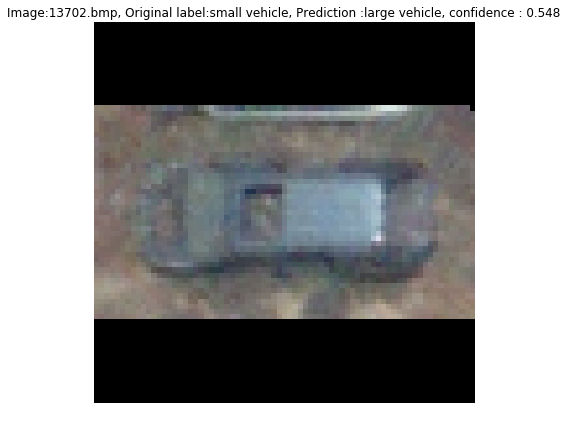

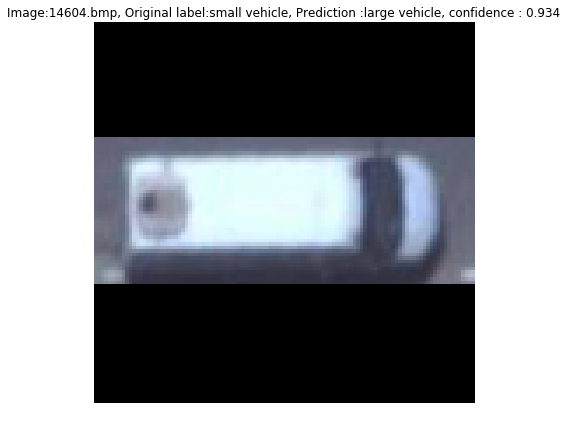

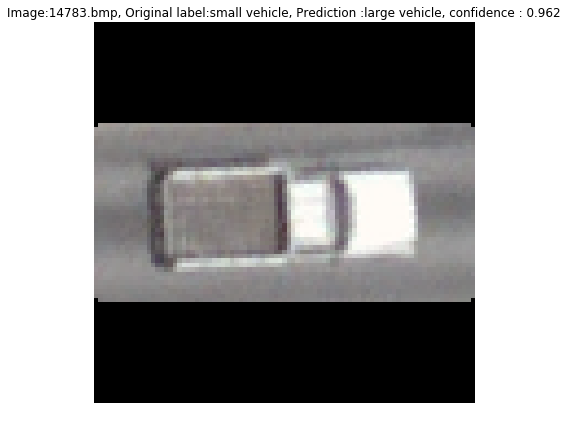

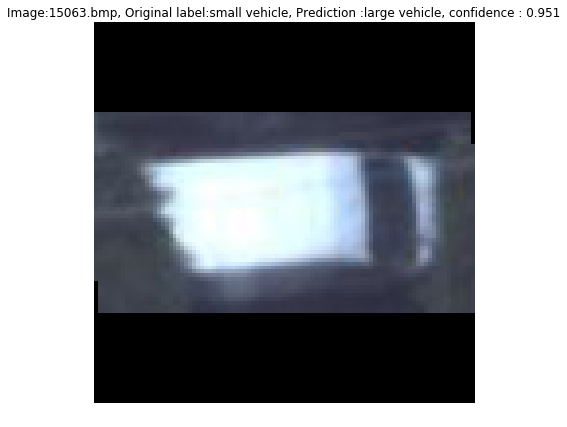

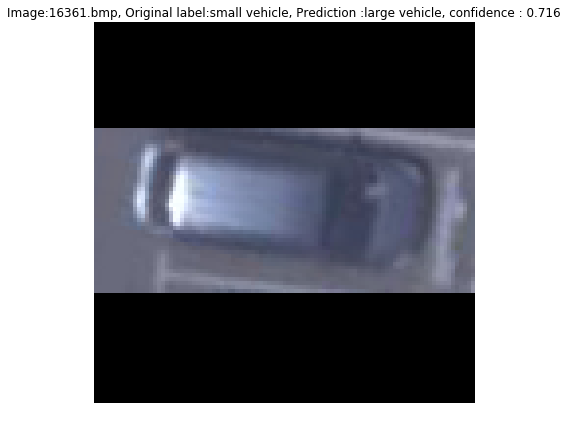

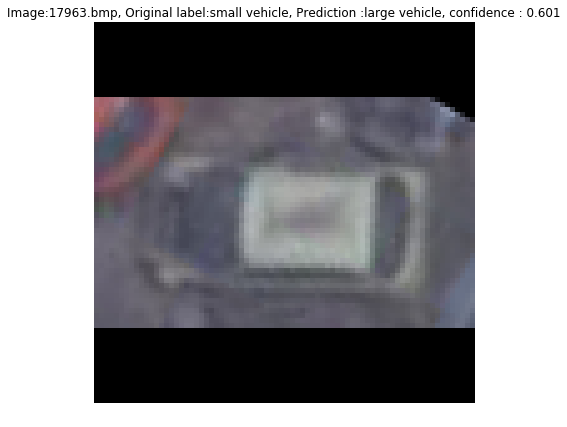

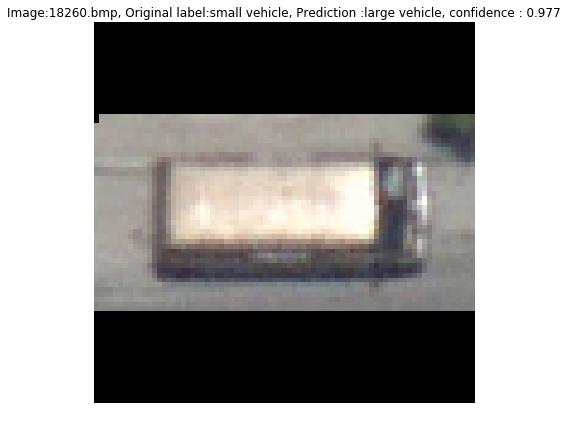

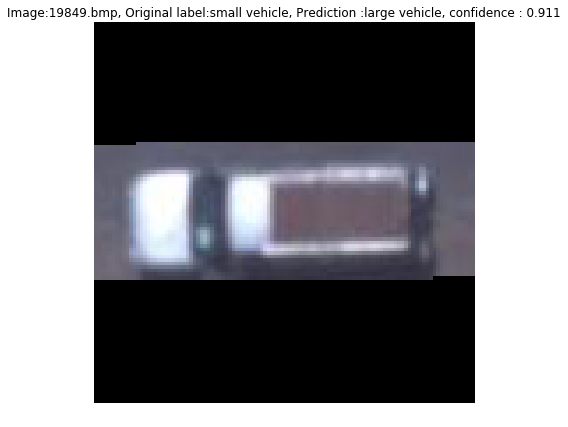

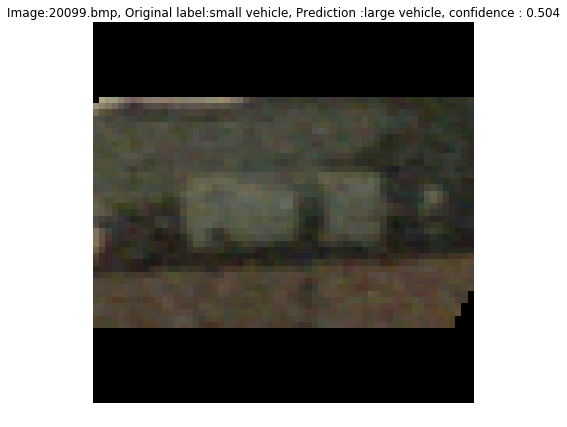

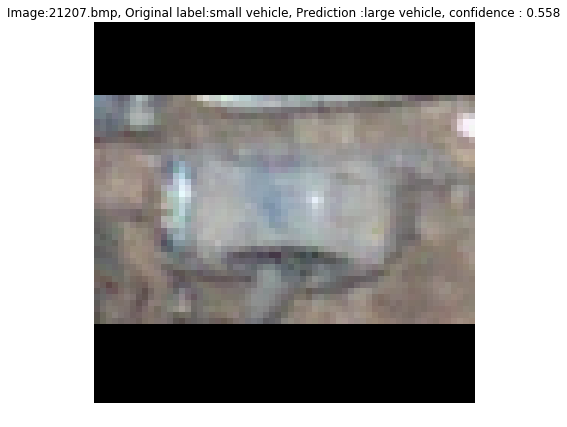

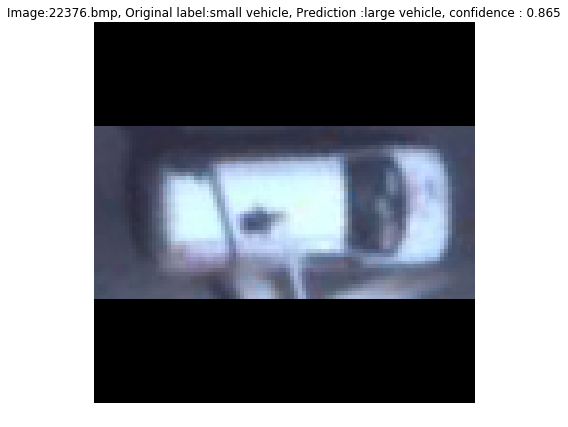

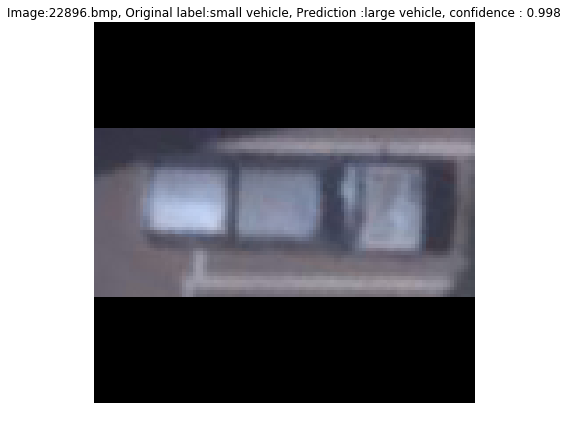

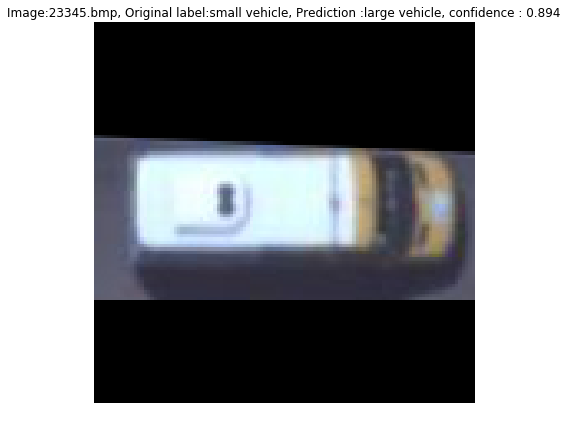

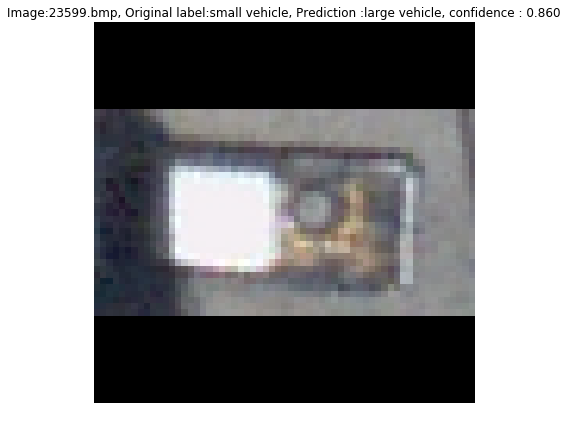

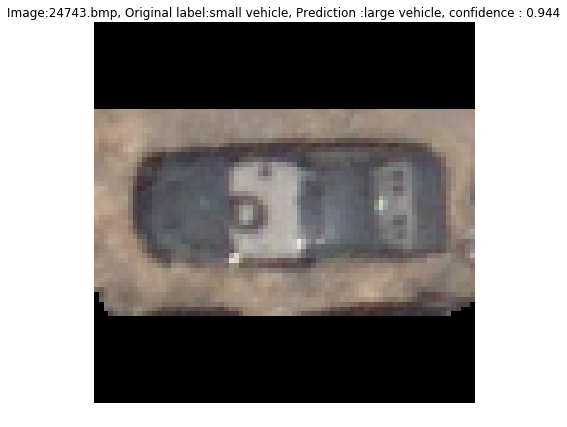

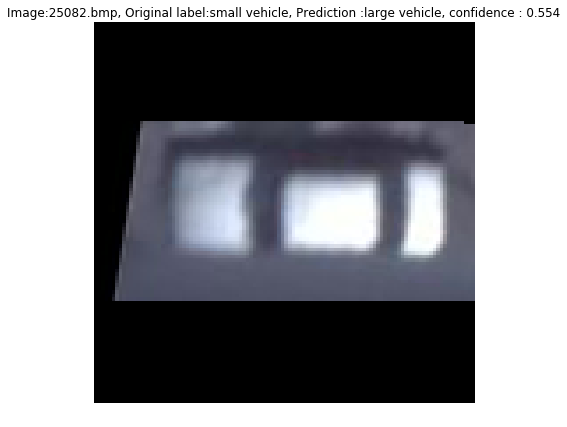

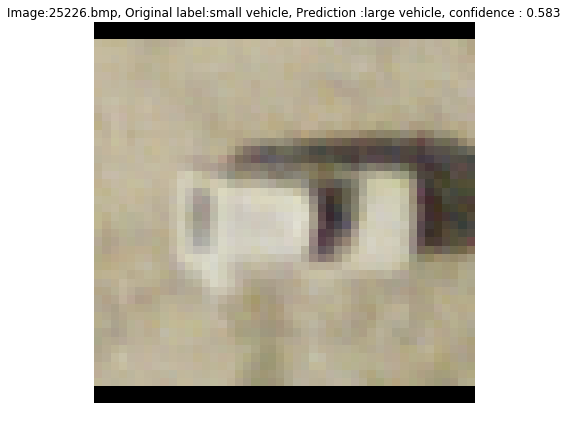

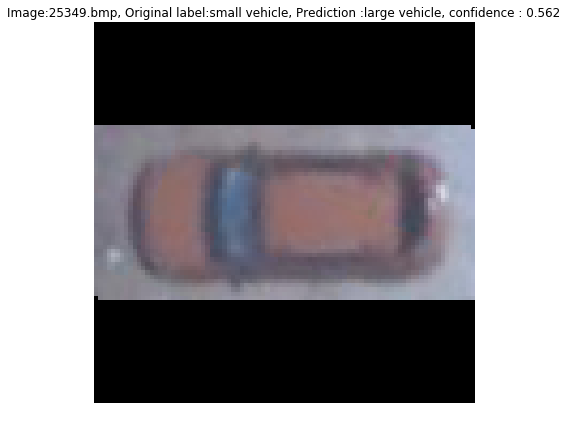

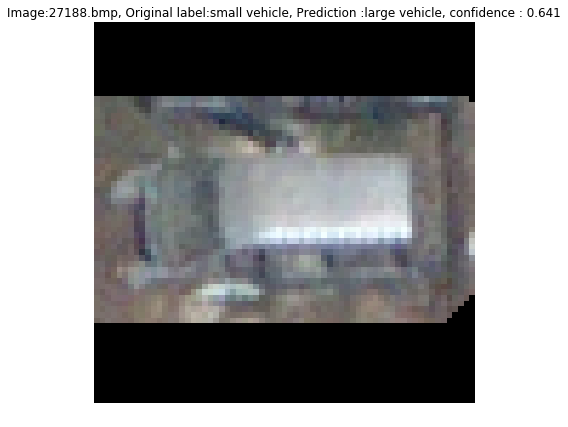

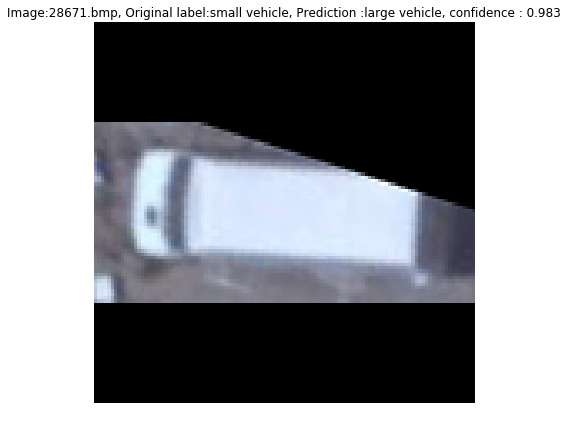

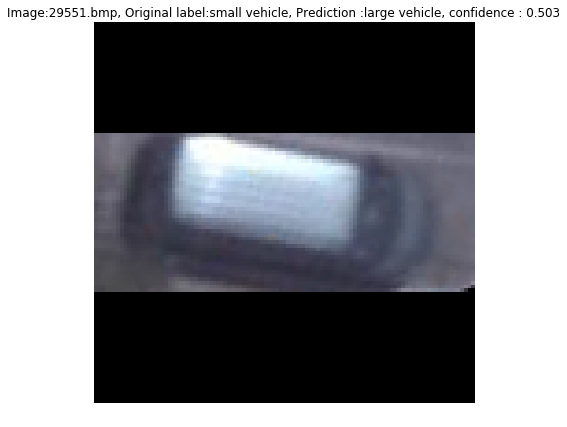

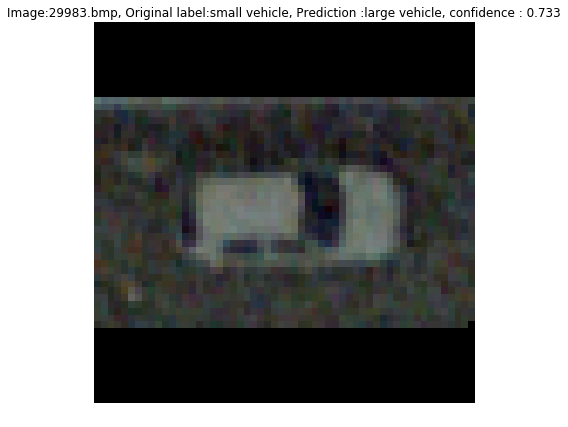

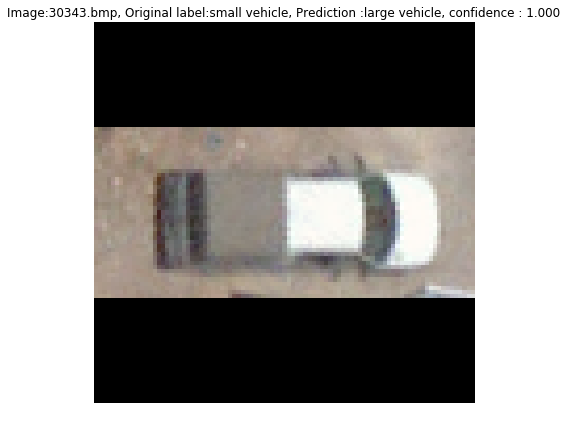

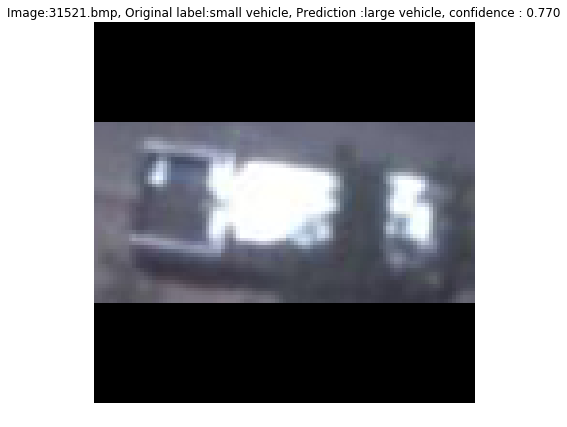

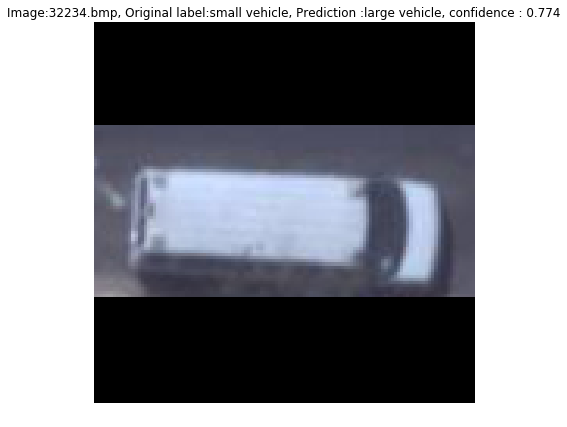

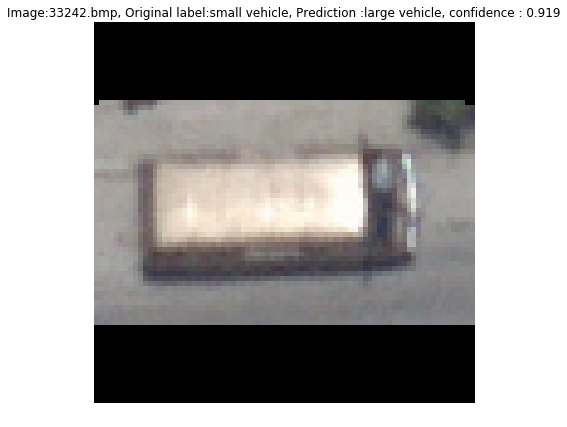

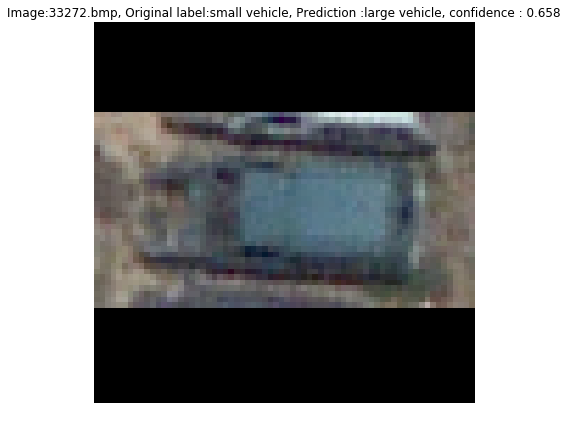

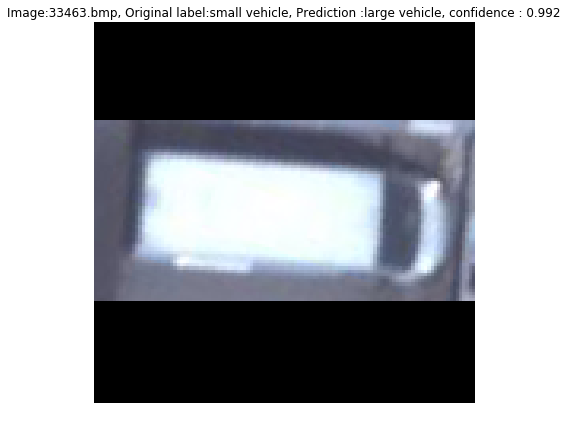

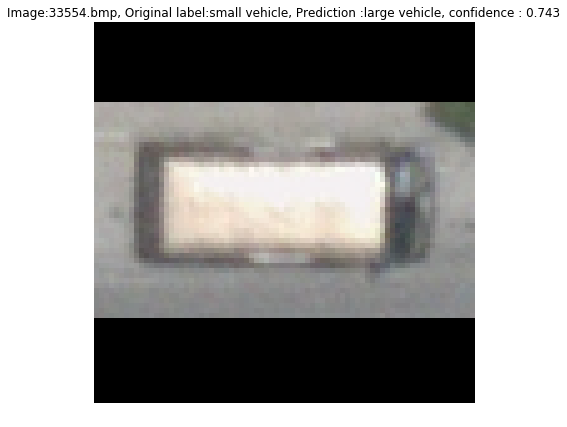

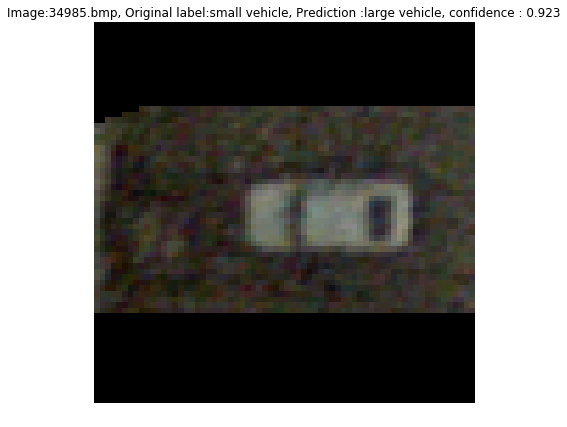

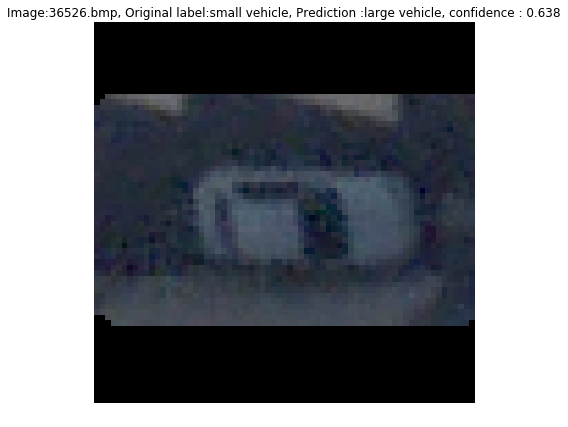

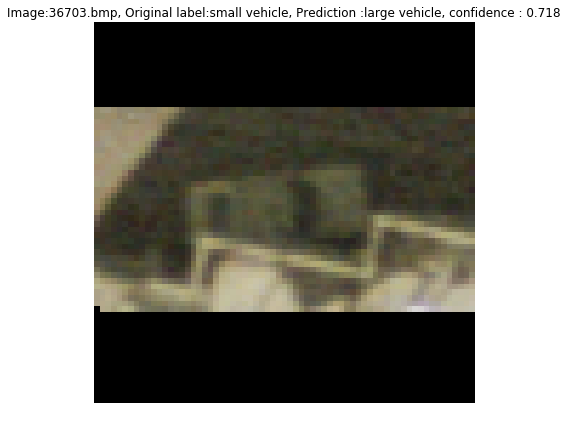

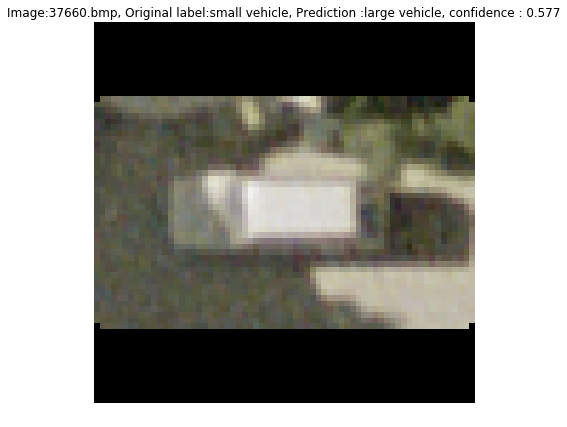

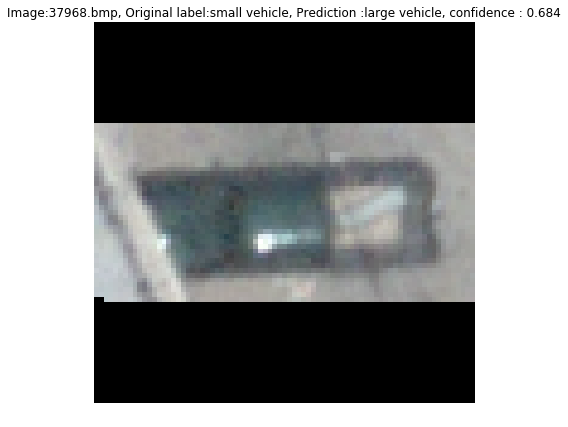

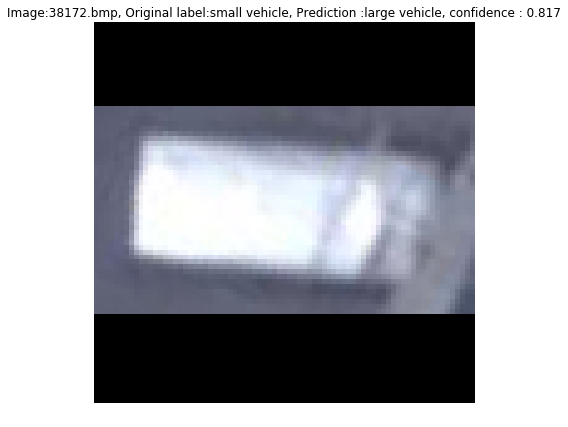

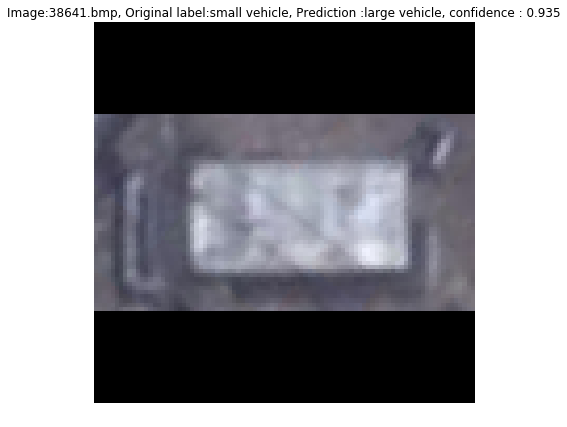

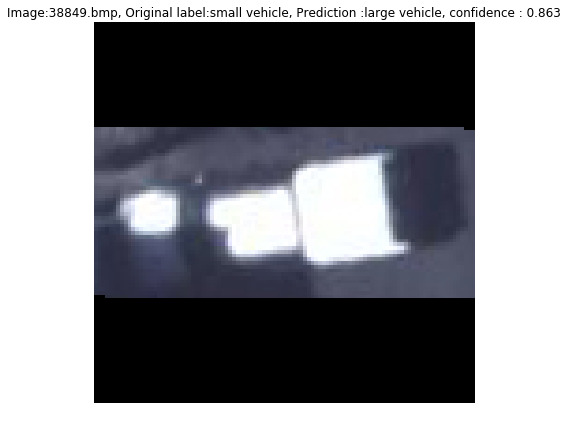

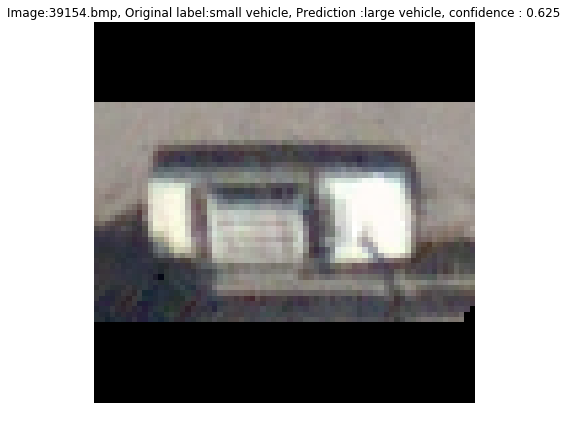

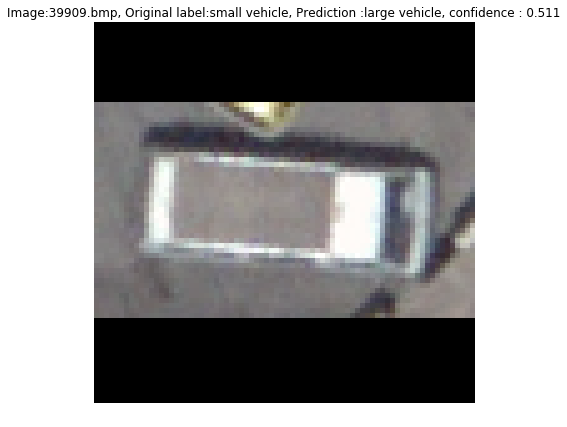

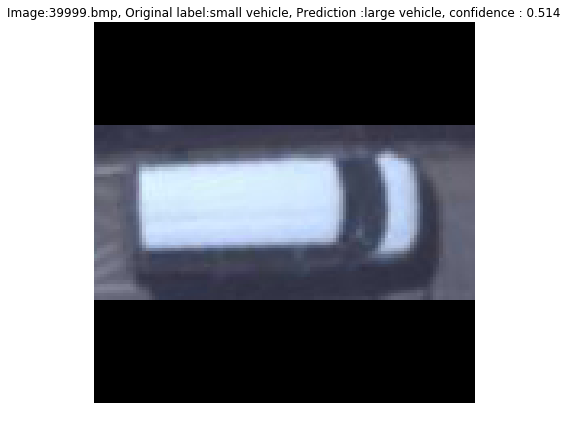

In [40]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

from keras.models import load_model

# model = load_model('balanced_train_general_class.h5')
# result: No of errors = 104/2324

# model = load_model('general_class_retrain_subclass.h5')
# result: No of errors = 124/2324

model = load_model('ver2_general_class.h5')

# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=validation_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Image:{}, Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[1],
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [61]:
import pandas as pd

segment = 'general_class'
image_size=224
model = load_model('balanced_train_{}.h5'.format(segment))

test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = 'test_mini'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

test_generator.reset()
pred=model.predict_generator(test_generator,steps=test_generator.samples,verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
tag_ids=list(map(lambda x: x.split('/')[1].split('.')[0], filenames))
results=pd.DataFrame({
    "Filename":filenames,
    "Predictions":predictions,
    "prediction_idx":predicted_class_indices,
    "tag_id":tag_ids
})
for idx, label in labels.items():
    results[label] = pred[:,idx]
    
results.to_csv("results_{}.csv".format(segment),index=False)

df_answer = pd.read_csv('answer.csv')

for label in labels.values():
    sorted_by_feature = results.sort_values(by=label, ascending=False)
    tags = sorted_by_feature['tag_id'].tolist()
    df_answer[label] = tags

df_answer.to_csv('answer.csv',index=False)

Found 11 images belonging to 1 classes.
11/11 [==============================] - 6s 583ms/step


In [54]:
print(sorted_by_feature['tag_id'])
results.head(20)

1     11029
5     19818
6     21886
7     22392
0     10792
2     14584
3     17503
8     24737
4     19566
9     25221
10    25401
Name: tag_id, dtype: object


,Filename,Predictions,prediction_idx,tag_id,large vehicle,small vehicle
0,all/10792.bmp,small vehicle,1,10792,1.185239e-03,0.998815
1,all/11029.bmp,small vehicle,1,11029,0.000000e+00,1.000000
2,all/14584.bmp,small vehicle,1,14584,7.547666e-03,0.992452
3,all/17503.bmp,small vehicle,1,17503,1.598829e-02,0.984012
4,all/19566.bmp,small vehicle,1,19566,1.756974e-01,0.824303
5,all/19818.bmp,small vehicle,1,19818,0.000000e+00,1.000000
6,all/21886.bmp,small vehicle,1,21886,5.610733e-16,1.000000
7,all/22392.bmp,small vehicle,1,22392,0.000000e+00,1.000000
8,all/24737.bmp,small vehicle,1,24737,1.377752e-01,0.862225
9,all/25221.bmp,small vehicle,1,25221,1.972929e-01,0.802707
